In [ ]:
!pip install xeno-canto

In [ ]:
# Download only the metadata
import json

!xeno-canto -m grp:"bats" q:"A"

# Uncomment the next line to get all data (WARNING 10 GiB)
# !xeno-canto -dl grp:"bats" q:"A"

dir = "dataset/metadata/grp_batsq_A"

with open(dir+"/page1.json", 'r') as file:
    data = json.load(file)
    print("API message:", data["message"])
    print("Number of recordings:", data["numRecordings"])
    print("Number of pages:", data["numPages"])

In [ ]:
import os
import json
import pandas as pd

# Convert metadata into frames
frames = []
for entry in os.scandir(dir):
    if entry.is_file():
        with open(entry, 'r') as file:
            data = json.load(file)
            df = pd.DataFrame(data['recordings'])
            frames.append(df)

all_data = pd.concat(frames)

# Print some metadata
print (all_data.columns.values.tolist())


# all_data.head()

# print(all_data)


In [ ]:
def to_seconds(x):
    mins, secs = map(float, x.split(':'))
    return mins * 60 + secs

all_data['length'] = all_data['length'].apply(to_seconds)
all_data = all_data.rename(columns={"gen": "genus", "en": "english_name", "cnt": "country", "type": "call_type", "length": "audio_length", "dvc": "device", "mic": "microphone"})
data = all_data[["id", "genus", "english_name", "country", "call_type", "sex", "audio_length", "device", "microphone"]]
data.head()


In [ ]:
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of bat genus")
seaborn.histplot(x="genus", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of bat sex")
seaborn.histplot(x="sex", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of country of observation")
seaborn.histplot(x="country", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of call type")
seaborn.histplot(x="call_type", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax = seaborn.histplot(x="audio_length", data=data)
ax.set_title("Histogram of audio fragment duration")
ax.set_xlabel("Audio duration (s)")

In [2]:
!pip install pathlib

In [ ]:
import os
from pathlib import Path
import re

def get_root():
    current_path = os.getcwd()
    parts = re.split(r"[\\/]", current_path)
    cwd = parts[-1]
    if cwd == "APPLIED-ML-TEMPLATE":
        print(f"APPLIED-ML-TEMPLATE found, ")
    else:
        current_path


path = os.getcwd()
print(f"path: {path}")
parts = re.split(r"[\\/]", path)
print(f"last part: {parts[-1]}")

print(Path(os.getcwd()).resolve())

# def get_project_root():
#     """Returns the absolute path to the project root, whether running from a script or a notebook."""
#     try:
#         path = Path(__file__).resolve().parent
#         splitpath = re.split(r"[\\/]", path)
#         print(splitpath[-1])
#         # If running from a .py script
#         return Path(__file__).resolve().parent
#     except NameError:
#         # If running from a Jupyter notebook
#         path = Path(os.getcwd()).resolve()
#         splitpath = re.split(r"[\\/]", path)
#         print(splitpath[-1])
#         return Path(os.getcwd()).resolve()


# Get the project root
# print(get_project_root())

path: c:\Users\Gebruiker\Documents\year 2 AI\2b\Applied-ML-Template\notebooks
last part: notebooks
C:\Users\Gebruiker\Documents\year 2 AI\2b\Applied-ML-Template\notebooks


In [27]:
from pathlib import Path
import os

#   for notebook:
BASE_DIR = Path(os.getcwd()).resolve().parent
print(BASE_DIR)
#   Uncomment for python file:
# BASE_DIR = Path(__file__).resolve().parent

audio_path = BASE_DIR / "data" / "sample" / "931377.wav"


C:\Users\Gebruiker\Documents\year 2 AI\2b\Applied-ML-Template


In [ ]:
from pydub import AudioSegment, effects
from scipy.io import wavfile
from scipy.signal import spectrogram
import tempfile

from sklearn.feature_selection import f_classif

def preprocess(filepath):
    raw = AudioSegment.from_file(filepath)
    # convert to mono
    if raw.channels > 1:
        raw = raw.set_channels(1)
    # normalize loudness
    normalized = effects.normalize(raw)

    # convert to wav
    # (I did not know about this myzelf, but my buddy told me)
    tempfile_name = tempfile.mktemp(suffix=".wav")
    normalized.export(tempfile_name, format="wav")

    # read wav file
    sr, data = wavfile.read(tempfile_name)

    # generate spectogram, fs=sr, otherwise it will be 1, which messes up the spectrogram
    fbin = 250
    f, t, sxx = spectrogram(data, fs=sr, nfft=sr/fbin)  # (f:ndarray, t:ndarray, Sxx:ndarray)

    min_freq = 10000
    max_freq = 80000
    # slice spectrogram
    frequency_mask = (f >= min_freq) & (f <= max_freq) # boolean mask, [F, F, T, T, F]
    sxx = sxx[frequency_mask]
    f = f[frequency_mask]

    # padding
    pad_width_begin = (int(f[0])-min_freq) // fbin
    pad_width_end = (max_freq-int(f[-1])) // fbin
    print(f'pad_width_begin: {pad_width_begin}, pad_width_end: {pad_width_end}')
    print(f'{int(f[0])}, {int(f[-1])}')
    sxx = np.pad(sxx, ((pad_width_begin, pad_width_end), (0, 0)), mode='constant', constant_values=0)
    f = np.arange(min_freq, max_freq+fbin, fbin)     

    # source:
    # https://medium.com/@purushottamgupta2010/splitting-audio-files-into-manageable-segments-with-python-890aba53d254
    # split audio into 1s segments
    total_length = len(t)
    segment_length = 1000 # in ms
    num_segments = math.ceil(total_length / segment_length)

    segments = []
    for i in range(num_segments):
        start_time = i * segment_length
        end_time = min((i + 1) * segment_length, total_length)
        t_sliced = t[start_time:end_time]
        sxx_sliced = sxx[:, start_time:end_time]
        segments.append((f, t_sliced, sxx_sliced))

    return segments

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the spectrogram
def plot_spectrogram(f, t, Sxx, title="Spectrogram"):
    plt.pcolormesh(t, f, np.log(Sxx), shading="gouraud")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    plt.title(f"Spectrogram of {title}")
    plt.ylim(0, 100000)  # Zoom into the frequency range of interest (up to 100 kHz)
    plt.colorbar(label="Log Intensity")
    plt.show()

In [73]:
# TEST

paths = [
    BASE_DIR / "data" / "sample" / "931377.wav",
    BASE_DIR / "test_data" / "XC831094 - Watervleermuis - Myotis daubentonii.wav",
    BASE_DIR
    / "test_data"
    / "XC928997 - Gewone dwergvleermuis - Pipistrellus pipistrellus.wav",
    BASE_DIR
    / "test_data"
    / "XC930778 - Gewone dwergvleermuis - Pipistrellus pipistrellus.wav",
    BASE_DIR
    / "test_data"
    / "XC931826 - Gewone dwergvleermuis - Pipistrellus pipistrellus (1).wav",
    BASE_DIR/  "test_data" / "XC931377 - Watervleermuis - Myotis daubentonii (1).wav",
]

# # Clamp max_freq to what’s actually available
# for path in paths:
#     f, t, sxx = preprocess(path)
#     print(f"f: {f}")
#     print(f"t: {t}")
#     print(f"sxx: {sxx}")
#     print(f"f.shape: {f.shape}")
#     sr = 96000

# Sampling rates:
for path in paths:
    f, t, sxx = preprocess(path)
    print(f"f: {f}\n")
    print(f'shape: {sxx.shape}')
    print((f'len(t): {len(t)}'))


pad_width_begin: 0, pad_width_end: 128
10000, 48000
f: [10000 10250 10500 10750 11000 11250 11500 11750 12000 12250 12500 12750
 13000 13250 13500 13750 14000 14250 14500 14750 15000 15250 15500 15750
 16000 16250 16500 16750 17000 17250 17500 17750 18000 18250 18500 18750
 19000 19250 19500 19750 20000 20250 20500 20750 21000 21250 21500 21750
 22000 22250 22500 22750 23000 23250 23500 23750 24000 24250 24500 24750
 25000 25250 25500 25750 26000 26250 26500 26750 27000 27250 27500 27750
 28000 28250 28500 28750 29000 29250 29500 29750 30000 30250 30500 30750
 31000 31250 31500 31750 32000 32250 32500 32750 33000 33250 33500 33750
 34000 34250 34500 34750 35000 35250 35500 35750 36000 36250 36500 36750
 37000 37250 37500 37750 38000 38250 38500 38750 39000 39250 39500 39750
 40000 40250 40500 40750 41000 41250 41500 41750 42000 42250 42500 42750
 43000 43250 43500 43750 44000 44250 44500 44750 45000 45250 45500 45750
 46000 46250 46500 46750 47000 47250 47500 47750 48000 48250 48500 48

In [38]:
print(f'f={f}, shape={f.shape}')

f=[10125. 10500. 10875. 11250. 11625. 12000. 12375. 12750. 13125. 13500.
 13875. 14250. 14625. 15000. 15375. 15750. 16125. 16500. 16875. 17250.
 17625. 18000. 18375. 18750. 19125. 19500. 19875. 20250. 20625. 21000.
 21375. 21750. 22125. 22500. 22875. 23250. 23625. 24000. 24375. 24750.
 25125. 25500. 25875. 26250. 26625. 27000. 27375. 27750. 28125. 28500.
 28875. 29250. 29625. 30000. 30375. 30750. 31125. 31500. 31875. 32250.
 32625. 33000. 33375. 33750. 34125. 34500. 34875. 35250. 35625. 36000.
 36375. 36750. 37125. 37500. 37875. 38250. 38625. 39000. 39375. 39750.
 40125. 40500. 40875. 41250. 41625. 42000. 42375. 42750. 43125. 43500.
 43875. 44250. 44625. 45000. 45375. 45750. 46125. 46500. 46875. 47250.
 47625. 48000.], shape=(102,)


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_36380\2450912013.py:6: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t, f, np.log(Sxx), shading="gouraud")


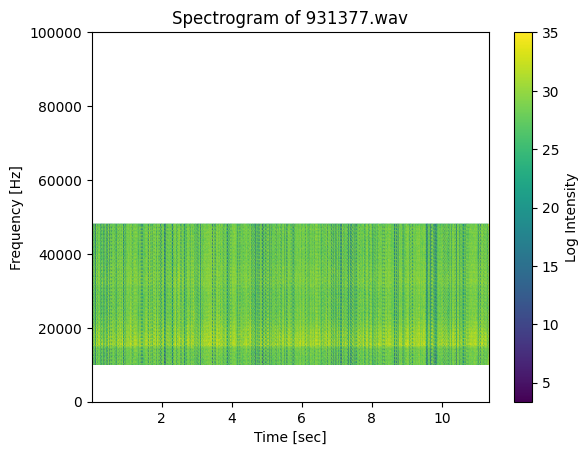

In [35]:
f, t, sxx = preprocess(audio_path)
plot_spectrogram(f, t, sxx, title="931377.wav")

In [ ]:

from pathlib import Path
import os

#   Uncomment for python file:
# BASE_DIR = Path(__file__).resolve().parent
#   for notebook:
BASE_DIR = Path(os.getcwd()).resolve().parent
print(BASE_DIR)

audio_path = BASE_DIR / "data" / "sample" / "931377.wav"

raw = AudioSegment.from_file(BASE_DIR / "data" / "sample" / "931377.wav")
normalized = effects.normalize(raw)

# export:
normalized.export(BASE_DIR / "data" / "sample" / "normalized_931377.wav", format="wav")

C:\Users\Gebruiker\Documents\year 2 AI\2b\Applied-ML-Template


FileNotFoundError: [WinError 2] Het systeem kan het opgegeven bestand niet vinden